# Проект: вариант 3

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

Был ли эксперимент успешен в целом.

In [40]:
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 6)

In [41]:
users_test = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/4XXIME4osGrMRA', sep = ';')
users_control_1 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/yJFydMNNGkEKfg', sep = ';')  
users_control_2 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/br6KkQupzzTGoQ', sep = ';') 
transactions_test = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/gvCWpZ55ODzs2g' , sep = ';')
transactions_control_1 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/VY5W0keMX5TZBQ', sep = ';') 
transactions_control_2 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/th5GL0mGOc-qzg', sep = ';')

# Предобработка и изучение данных

In [42]:
# Объединим транзакции и выделим пользователей, которые приобретали premium_no_trial
transactions_test['group'] = 'test'
transactions_control_1['group'] = 'control_1'
transactions_control_2['group'] = 'control_2'

df_transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2])

In [43]:
df_transactions.duplicated().sum()

662

In [44]:
#Есть дубликаты, нужно удалить
df_transactions = df_transactions.drop_duplicates()

In [45]:
# Есть логическая ошибка, регистрация не может быть позже покупки
df_transactions[df_transactions['joined_at'] > df_transactions['paid_at']]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
11,891861048.0,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588.0,68.0,none,premium_no_trial,test
20,891806280.0,United States of America,2017-10-27 08:56:00,2017-03-11 10:57:00,8242.0,147.0,trial_vip_popup,trial_premium,test
24,891786216.0,Spain,2017-10-27 18:20:00,2017-03-11 20:20:00,12818.0,147.0,trial_vip_popup,trial_premium,test
25,892057347.0,France,2017-10-21 23:15:00,2017-08-11 01:56:00,1209.0,19.0,none,coins,test
36,891589239.0,Italy,2017-10-31 14:16:00,2017-09-11 15:44:00,6305.0,19.0,empty_likes,coins,test
...,...,...,...,...,...,...,...,...,...
305,891606141.0,United States of America,2017-10-31 04:43:00,2017-03-11 21:13:00,3783.0,67.0,empty_likes,other_type,control_2
313,891691062.0,Belgium,2017-10-29 16:19:00,2017-05-11 18:35:00,16614.0,147.0,popular_users_block,trial_premium,control_2
314,892075512.0,United States of America,2017-10-21 16:58:00,2017-08-11 12:18:00,9958.0,147.0,trial_vip_popup,trial_premium,control_2
315,891722802.0,United States of America,2017-10-29 02:08:00,2017-05-11 05:49:00,12727.0,147.0,trial_vip_popup,trial_premium,control_2


In [46]:
df_transactions = df_transactions[df_transactions['joined_at'] <= df_transactions['paid_at']]

In [47]:
# Все платные продукты имеют ненулевую выручку
(df_transactions[df_transactions['product_type'].isin(['trial_premium', 'premium_no_trial', 'coins'])].revenue <=0).sum()

0

In [48]:
#Создание серии df_prem с булевскими значениями, указывающими, есть ли у пользователя премиум-подписка или нет
df_prem = df_transactions.groupby('uid')['product_type'].unique().apply(lambda row: 'premium_no_trial' in row)
df_prem

uid
891068079.0     True
891071157.0     True
891075072.0    False
891077727.0     True
891080040.0    False
               ...  
892434141.0     True
892435536.0     True
892438635.0    False
892438776.0    False
960936960.0    False
Name: product_type, Length: 451, dtype: bool

In [49]:
#Посмотрим на payment_id для покупателей premium_no_trial
df_transactions[df_transactions['product_type'] == 'premium_no_trial'].payment_id.value_counts()

147.0    214
68.0      38
0.0        4
Name: payment_id, dtype: int64

Есть три платежные системы, в условии говорится про две, предполагаем, что речь идет про "147" и "68".

In [50]:
#Выручка по каждому пользователю только по продукту premium_no_trial при покупке через две новые платежные системы
revenue_premium_no_trial = df_transactions[(df_transactions['product_type'] == 'premium_no_trial') & (df_transactions.payment_id != 0)].groupby('uid').revenue.sum()

In [51]:
#Добавим столбец в каждый пользовательский датафрейм, указывающий на принадлежность к определенной группе
users_test['group'] = 'test'
users_control_1['group'] = 'control_1'
users_control_2['group'] = 'control_2'

#Объединим пользовательские датафреймы
df_user = pd.concat([users_test, users_control_1, users_control_2])
df_user

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,test
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,test
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4259,891937401,63,242,NaN,Italy,"1,2",1,50,66,33,NaN,NaN,0,control_2
4260,891692844,35,500,NaN,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,NaN,NaN,0,control_2
4261,891096429,41,333,NaN,United States of America,NaN,1,38,44,6,NaN,NaN,0,control_2
4262,891697584,48,210,NaN,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,NaN,NaN,0,control_2


In [52]:
# Дубликатов нет
df_user.duplicated().sum()

0

In [53]:
# Оставим только те страны, которые присутствуют во всех группах
df_country = pd.pivot_table(df_user, index = 'country', columns = 'group', values = 'uid', aggfunc='count').dropna()
df_country

group,control_1,control_2,test
country,,,
Argentina,389.0,397.0,396.0
Australia,50.0,51.0,62.0
Belgium,108.0,90.0,92.0
Canada,134.0,134.0,137.0
Chile,287.0,286.0,272.0
Colombia,1.0,2.0,1.0
Costa Rica,1.0,1.0,1.0
Dominican Republic,2.0,1.0,1.0
France,370.0,376.0,359.0


In [54]:
#Отфильтруем датафрейм
df_user = df_user[df_user['country'].isin(df_country.index)]

In [55]:
#Добавим столбец с целевым действием
df_final = df_user.merge(df_prem, how = 'left', right_index=True, left_on = 'uid')

In [56]:
# Люди, которые совершали транзакции должны посетить хотя бы один раз
df_final[df_final.product_type.notna()].visit_days.isna().sum()

48

In [57]:
df_final = df_final[~((df_final.product_type.notna()) & (df_final.visit_days.isna()))]

In [58]:
#Нет пересечений среди пользователей тестовой и контрольных групп
set_1 = set(df_final[df_final.group == 'test'].uid)
set_2 = set(df_final[df_final.group == 'control_1'].uid)
set_3 = set(df_final[df_final.group == 'control_2'].uid)

print(set_1.intersection(set_2))
print(set_1.intersection(set_3))
print(set_2.intersection(set_3))

set()
set()
set()


In [59]:
#Добавили столбец дохода только c premium_no_trial при покупке через две новые платежные системы
df_final = df_final.merge(revenue_premium_no_trial, how = 'left', right_index=True, left_on = 'uid')
df_final

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,product_type,revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test,NaN,NaN
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,test,NaN,NaN
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test,NaN,NaN
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,test,NaN,NaN
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,test,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4259,891937401,63,242,NaN,Italy,"1,2",1,50,66,33,NaN,NaN,0,control_2,NaN,NaN
4260,891692844,35,500,NaN,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,NaN,NaN,0,control_2,NaN,NaN
4261,891096429,41,333,NaN,United States of America,NaN,1,38,44,6,NaN,NaN,0,control_2,NaN,NaN
4262,891697584,48,210,NaN,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,NaN,NaN,0,control_2,NaN,NaN


## Посмотрим на репрезентативность выборок

In [60]:
#Присвоим каждому пользователю возрастную группу, чтобы построить визуально читаемый график
def age(row):
    for i in range(18, 100, 10):
        if (row>=i) and (row<i+10):
            return str(i) +'-'+ str(i+10)
df_final['age_bin'] = df_final['age'].apply(age)
df_final

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,product_type,revenue,age_bin
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test,NaN,NaN,18-28
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,test,NaN,NaN,18-28
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test,NaN,NaN,38-48
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,test,NaN,NaN,28-38
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,test,NaN,NaN,18-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4259,891937401,63,242,NaN,Italy,"1,2",1,50,66,33,NaN,NaN,0,control_2,NaN,NaN,58-68
4260,891692844,35,500,NaN,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,NaN,NaN,0,control_2,NaN,NaN,28-38
4261,891096429,41,333,NaN,United States of America,NaN,1,38,44,6,NaN,NaN,0,control_2,NaN,NaN,38-48
4262,891697584,48,210,NaN,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,NaN,NaN,0,control_2,NaN,NaN,48-58


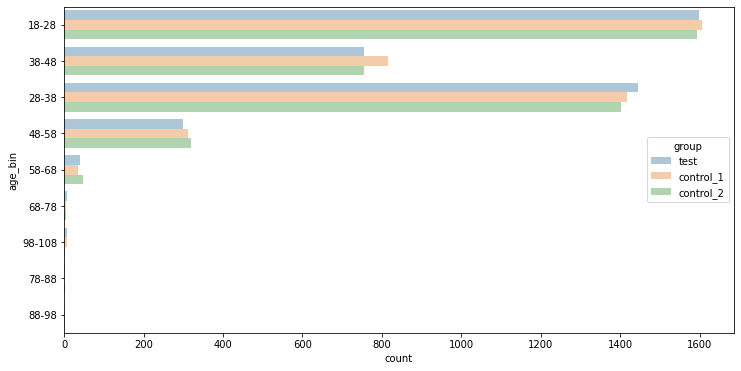

In [61]:
sns.countplot(data=df_final, y = 'age_bin', hue = 'group', alpha = 0.4);
# Распределение по возрасту примерно одинаковое, значит выборки репрезентативные

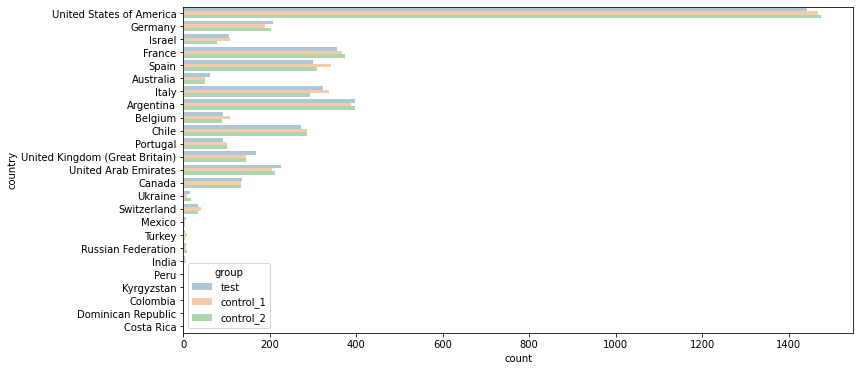

In [62]:
sns.countplot(data=df_final, y = 'country', hue = 'group', alpha = 0.4);
# Распределение по странам примерно одинаковое, значит выборки репрезентативные

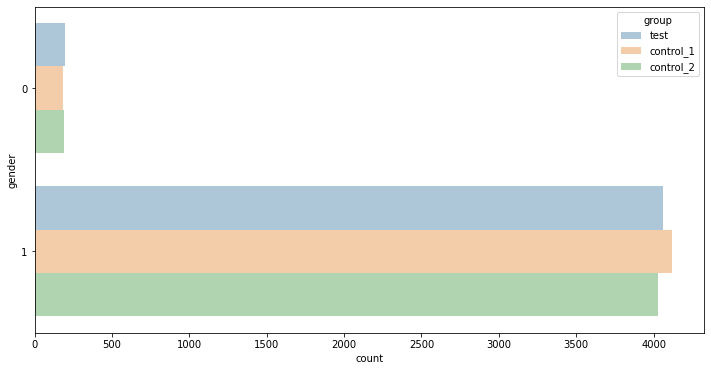

In [63]:
sns.countplot(data=df_final, y = 'gender', hue = 'group', alpha = 0.4);
# Распределение по полу примерно одинаковое, значит выборки репрезентативные

Вывод: все выборки репрезентативны

# Выбор целевых метрик

В качестве целевых метрик выберем:
1. Конверсия в premium_no_trial.

Эта метрика измеряет процент пользователей, которые решают оформить премиум-подписку без пробного периода. В данном контексте, она важна, так как помогает понять, насколько привлекательными считаются изменения в стоимости премиум-подписки и использование новых платежных систем новыми пользователями. Если конверсия в premium_no_trial вырастет, это может свидетельствовать о том, что изменения были успешными и привлекли больше пользователей.

2. Средняя выручка с пользователя только по одному продукту premium_no_trial при покупке через две новые платежные системы (назовем сокращенно СВ).

СВ является средним доходом, который мы получаем с каждого пользователя premium_no_trial при покупке через две новые платежные системы. В этом случае, мы хотим убедиться, что изменения в стоимости через две новые платежные системы не только увеличивают конверсию, но и увеличивают средний доход по одному продукту premium_no_trial. Если СВ также вырастет или останется стабильной, это может свидетельствовать о том, что изменения не только привлекли больше пользователей, но и увеличили их средний вклад в приложение.

Важно, что мы здесь для проверки берем revenue_premium_no_trial (доход с premium_no_trial при покупке через две новые платежные системы), чтобы получить наиболее точные результаты именно по выбранным условиям.

## Проверим, различаются ли конверсии в тестовой и контрольных группах

In [64]:
df_final

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,product_type,revenue,age_bin
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test,NaN,NaN,18-28
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,test,NaN,NaN,18-28
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test,NaN,NaN,38-48
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,test,NaN,NaN,28-38
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,test,NaN,NaN,18-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4259,891937401,63,242,NaN,Italy,"1,2",1,50,66,33,NaN,NaN,0,control_2,NaN,NaN,58-68
4260,891692844,35,500,NaN,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,NaN,NaN,0,control_2,NaN,NaN,28-38
4261,891096429,41,333,NaN,United States of America,NaN,1,38,44,6,NaN,NaN,0,control_2,NaN,NaN,38-48
4262,891697584,48,210,NaN,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,NaN,NaN,0,control_2,NaN,NaN,48-58


In [65]:
m_test = df_final[df_final.group == 'test']['product_type'].sum()
n_test = df_final[df_final.group == 'test']['product_type'].size

m_control_1 = df_final[df_final.group == 'control_1']['product_type'].sum()
n_control_1 = df_final[df_final.group == 'control_1']['product_type'].size

m_control_2 = df_final[df_final.group == 'control_2']['product_type'].sum()
n_control_2 = df_final[df_final.group == 'control_2']['product_type'].size

In [66]:
#Выборочные конверсии в группах
print(' Конверсия в test: ', m_test/n_test)
print(' Конверсия в control_1: ', m_control_1/n_control_1)
print(' Конверсия в control_2: ', m_control_2/n_control_2)

 Конверсия в test:  0.013151714419915453
 Конверсия в control_1:  0.019758251975825196
 Конверсия в control_2:  0.01966824644549763


Проведем тест Хи-квадрат, чтобы определить статистическое различие в группах по конверсии в premium no-trial.
Мы выбрали этот статистический тест, потому что:
- Конверсия в "premium_no_trial" представляет собой категориальную переменную, так как она измеряет, сколько пользователей выбрало опцию "premium_no_trial" из двух категорий (да или нет).
- Наблюдения между группами независимы. В случае A/B теста, наблюдения пользователей в одной группе не влияют на наблюдения в другой группе, что делает этот тест подходящим.
- Большие выборки: Тест Хи-квадрат часто требует больших выборок для достижения статистической значимости. 

### Гипотезы

Сначала сравним контрольные группы для того, чтобы убедиться, что контрольные группы однородные и значимо не различаются, иначе это может свидетельствовать о неправильном дизайне эксперимента.

H0: в 1 контрольной и 2 контрольной группе нет стат различий в конверсиях

H1: в 1 контрольной и 2 контрольной группе есть стат различия в конверсиях

In [67]:
table_control  = [[m_control_1, n_control_1 - m_control_1], [m_control_2, n_control_2 - m_control_2]]
result_3 = chi2_contingency(table_control)
p3 = result_3[1]
print('p-value равен', p3)

p-value равен 1.0


p-value > 0.05, значит, нет основания отвергнуть гипотезу H0, следовательно изменение в конверсиях контрольных групп значимо не отличается

### Гипотезы

H0: в тестовой и 1 контрольной группе нет статистически значимых различий в конверсиях

H1: в тестовой и 1 контрольной группе есть статистически значимые различие в конверсиях

In [68]:
# Проведем тест Хи-квадрат, чтобы определить статистическое различие в группах по конверсии в premium no-trial
table_1_test  = [[m_test, n_test - m_test], [m_control_1, n_control_1 - m_control_1]]
result_1 = chi2_contingency(table_1_test)
p1 = result_1[1]
print('p-value равен', p1)

p-value равен 0.0205487393197892


p-value < 0.05, значит, есть основание отвергнуть гипотезу H0, следовательно изменение в конверсиях тестовой и 1й контрольной группы значимо отличается (конверсия тестовой группы снижается)

### Гипотезы

H0: в тестовой и 2 контрольной группе нет стат различий в конверсиях

H1: в тестовой и 2 контрольной группе есть стат различия в конверсиях

In [69]:
table_2_test  = [[m_test, n_test - m_test], [m_control_2, n_control_2 - m_control_2]]
result_2 = chi2_contingency(table_2_test)
p2 = result_2[1]
print('p-value равен', p2)

p-value равен 0.02279216249741696


p-value < 0.05, значит, есть основание отвергнуть гипотезу H0, следовательно изменение в конверсиях тестовой и 2й контрольной группы значимо отличается (конверсия тестовой группы снижается)

# Проверим, отличается ли статистически значимо средняя выручка только по premium_no_trial при покупке через две новые платежные системы

In [70]:
df_final

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,product_type,revenue,age_bin
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test,NaN,NaN,18-28
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,test,NaN,NaN,18-28
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test,NaN,NaN,38-48
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,test,NaN,NaN,28-38
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,test,NaN,NaN,18-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4259,891937401,63,242,NaN,Italy,"1,2",1,50,66,33,NaN,NaN,0,control_2,NaN,NaN,58-68
4260,891692844,35,500,NaN,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,NaN,NaN,0,control_2,NaN,NaN,28-38
4261,891096429,41,333,NaN,United States of America,NaN,1,38,44,6,NaN,NaN,0,control_2,NaN,NaN,38-48
4262,891697584,48,210,NaN,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,NaN,NaN,0,control_2,NaN,NaN,48-58


In [71]:
test = df_final[(df_final['revenue'].notna()) & (df_final['group'] == 'test')]['total_revenue']
control_1 = df_final[(df_final['revenue'].notna()) & (df_final['group'] == 'control_1')]['total_revenue']
control_2 = df_final[(df_final['revenue'].notna()) & (df_final['group'] == 'control_2')]['total_revenue']

In [72]:
print('Средний чек в test: ', test.mean())
print('Средний чек в control_1: ', control_1.mean())
print('Средний чек в control_2: ', control_2.mean())

Средний чек в test:  19009.946428571428
Средний чек в control_1:  17065.176470588234
Средний чек в control_2:  10368.674698795181


Проведем t_test, потому что:
- Выборки большие, нормальность для групп не требуется и можно использовать t_test для проверки СВ.
- Непрерывные данные: СВ представляет собой непрерывную переменную, так как она измеряет средний доход с каждого платящего пользователя в денежных единицах.
- Независимость выборок: t_test подходит, когда выборки независимы. В случае A/B теста, данные из разных групп считаются независимыми.
- Сравнение средних значений: t_test позволяет сравнить средние значения между двумя группами и определить, есть ли статистически значимое различие между ними.

### Гипотезы

Сначала сравним контрольные группы для того, чтобы убедиться, что контрольные группы однородные и значимо не различаются, иначе это может свидетельствовать о неправильном дизайне эксперимента.

СВ - Средняя выручка с пользователя только по одному продукту premium_no_trial при покупке через две новые платежные системы.

H0: СВ в контрольных группах не отличается статистически значимо

H1: СВ в контрольных группах отличается статистически значимо

In [73]:
pv3 = ttest_ind(transactions_control_1.revenue.dropna(), transactions_control_2.revenue.dropna()).pvalue
print('p-value равен', pv3)

p-value равен 0.05463990982288066


p-value > 0.05 , следовательно нет оснований отвергнуть H0, различие незначимо

### Гипотезы

H0: СВ в тестовой и первой контрольной не отличается статистически значимо

H1: СВ в тестовой и первой контрольной отличается result_3 значимо

In [74]:
pv1 = ttest_ind(test, control_1).pvalue
print('p-value равен', pv1)

p-value равен 0.7995067671845772


p-value > 0.05, значит, нет оснований отвергнуть H0, следовательно различие между тестовой и первой контрольной группой статистически незначимо

### Гипотезы

H0: СВ в тестовой и второй контрольной не отличается статистически значимо

H1: СВ в тестовой и второй контрольной не отличается статистически значимо

In [75]:
pv2 = ttest_ind(test, control_2).pvalue
print('p-value равен', pv2)

p-value равен 0.009398483628569479


p-value < 0.05, значит, есть основание отвергнуть гипотезу H0, следовательно различие статистически значимо (в тестовой группе средний чек больше)

# Вывод

В данном эксперименте мы использовали две метрики для анализа эффективности нововведения: Конверсия в premium_no_trial и Средняя выручка с пользователя только по одному продукту premium_no_trial при покупке через две новые платежные системы (сокращенно СВ).

Эксперимент не был успешен в достижении первоначальных целей. По первой метрике (конверсия) было выявлено, что изменение стоимости премиум-подписки через две новые платежные системы уменьшает конверсию в премиум подписку. Этот эффект был статистически значимым (в сравнении с двумя контрольными группами).

С другой стороны, по второй метрике мы обнаружили, что в тестовой группе СВ была выше и статистически значимо отличалась только от второй контрольной группы (повышался в тестовой группе).

Обобщая, хотя изменение стоимости премиум-подписки через две новые платежные системы привело к повышению СВ по сравнению со второй контрольной группой, оно также снизило конверсию. 

Анализируя результаты А/Б тестирования, можно прийти в выводу, что эксперимент не был успешным, потому что:

1) Конверсия тестовой группы статистически значимо понизилась по отношению к обеим контрольным группам.

2) Средняя выручка с пользователя по одному продукту premium_no_trial при покупке через две новые платежные системы в тестовой группе статистически значимо возросла только по отношению одной из двух контрольных групп.

Данное исследование показывает, что изменение стоимости premium_no_trial при покупке через две новые платежные системы не пойдет на пользу бизнесу, или принесет незначительную пользу, не сопоставимую с возможными затратами по внедрению новшеств в приложение.

Окончательное решение по данному изменению ценовой политики должно быть принято с учетом всех выявленных факторов и целей бизнеса.

Примечание

Результаты исследования могут быть неточными в том моменте, что невозможно определить старых и новых пользователей (каких считать новыми, а каких - старыми), потому что неизвестна временная точка, от которой пользователи начинают считаться новыми. Неизвестно начало эксперимента, и это условие нет возможности соблюсти.